# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:15<00:00, 3.83KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

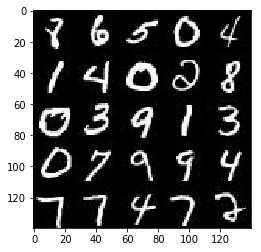

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

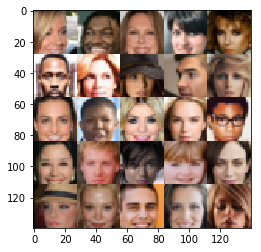

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/DruidKuma/miniconda3/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        drop2 = tf.nn.dropout(bn2, 0.9)
        relu2 = tf.maximum(alpha * drop2, drop2)
        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        drop3 = tf.nn.dropout(bn3, 0.9)
        relu3 = tf.maximum(alpha * drop3, drop3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    step = 1
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                
                if step % 100 == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}.\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}; ".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                
                if step % 1000 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2.	 Discriminator Loss: 2.3882;  Generator Loss: 1.4772
Epoch 1/2.	 Discriminator Loss: 1.6408;  Generator Loss: 0.3924
Epoch 1/2.	 Discriminator Loss: 1.4968;  Generator Loss: 0.7719
Epoch 1/2.	 Discriminator Loss: 1.6865;  Generator Loss: 0.4241
Epoch 1/2.	 Discriminator Loss: 1.7420;  Generator Loss: 0.3363
Epoch 1/2.	 Discriminator Loss: 1.6341;  Generator Loss: 0.4976
Epoch 1/2.	 Discriminator Loss: 1.5700;  Generator Loss: 1.2759
Epoch 1/2.	 Discriminator Loss: 1.8050;  Generator Loss: 0.3246
Epoch 1/2.	 Discriminator Loss: 1.4887;  Generator Loss: 0.5525
Epoch 1/2.	 Discriminator Loss: 1.2569;  Generator Loss: 0.5703


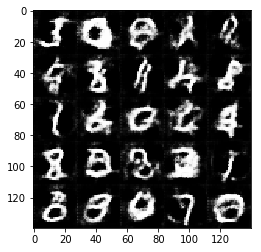

Epoch 1/2.	 Discriminator Loss: 1.3652;  Generator Loss: 0.6112
Epoch 1/2.	 Discriminator Loss: 1.6318;  Generator Loss: 0.4342
Epoch 1/2.	 Discriminator Loss: 1.2944;  Generator Loss: 0.6882
Epoch 1/2.	 Discriminator Loss: 1.4267;  Generator Loss: 1.1967
Epoch 1/2.	 Discriminator Loss: 1.2894;  Generator Loss: 0.8096
Epoch 1/2.	 Discriminator Loss: 1.4327;  Generator Loss: 0.7228
Epoch 1/2.	 Discriminator Loss: 1.2484;  Generator Loss: 1.1628
Epoch 1/2.	 Discriminator Loss: 1.1301;  Generator Loss: 0.6452
Epoch 1/2.	 Discriminator Loss: 1.3325;  Generator Loss: 0.6762
Epoch 1/2.	 Discriminator Loss: 1.4521;  Generator Loss: 0.8537


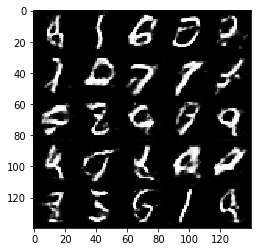

Epoch 1/2.	 Discriminator Loss: 1.3737;  Generator Loss: 0.6586
Epoch 1/2.	 Discriminator Loss: 1.1091;  Generator Loss: 1.5058
Epoch 1/2.	 Discriminator Loss: 1.2578;  Generator Loss: 0.5407
Epoch 1/2.	 Discriminator Loss: 1.1951;  Generator Loss: 0.6907
Epoch 1/2.	 Discriminator Loss: 1.7383;  Generator Loss: 2.0671
Epoch 1/2.	 Discriminator Loss: 1.5117;  Generator Loss: 0.9569
Epoch 1/2.	 Discriminator Loss: 1.0117;  Generator Loss: 1.0568
Epoch 1/2.	 Discriminator Loss: 1.5811;  Generator Loss: 0.4739
Epoch 1/2.	 Discriminator Loss: 1.4951;  Generator Loss: 1.3708
Epoch 1/2.	 Discriminator Loss: 2.0995;  Generator Loss: 0.2755


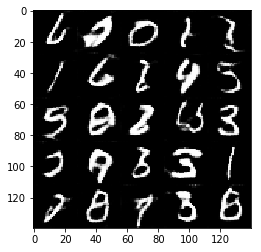

Epoch 1/2.	 Discriminator Loss: 1.3281;  Generator Loss: 0.7569
Epoch 1/2.	 Discriminator Loss: 1.3113;  Generator Loss: 0.5304
Epoch 1/2.	 Discriminator Loss: 1.0493;  Generator Loss: 1.5283
Epoch 1/2.	 Discriminator Loss: 1.1201;  Generator Loss: 0.6783
Epoch 1/2.	 Discriminator Loss: 1.2856;  Generator Loss: 0.6185
Epoch 1/2.	 Discriminator Loss: 1.6776;  Generator Loss: 0.2946
Epoch 1/2.	 Discriminator Loss: 1.2423;  Generator Loss: 0.6398
Epoch 1/2.	 Discriminator Loss: 0.9623;  Generator Loss: 0.9727
Epoch 1/2.	 Discriminator Loss: 1.1422;  Generator Loss: 1.2454
Epoch 1/2.	 Discriminator Loss: 1.4618;  Generator Loss: 0.9059


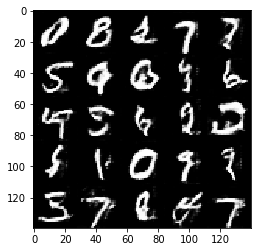

Epoch 1/2.	 Discriminator Loss: 1.1890;  Generator Loss: 1.2391
Epoch 1/2.	 Discriminator Loss: 1.2867;  Generator Loss: 0.5207
Epoch 1/2.	 Discriminator Loss: 1.4371;  Generator Loss: 0.5274
Epoch 1/2.	 Discriminator Loss: 1.3023;  Generator Loss: 0.5291
Epoch 1/2.	 Discriminator Loss: 1.2882;  Generator Loss: 0.4994
Epoch 1/2.	 Discriminator Loss: 1.0174;  Generator Loss: 0.9244
Epoch 1/2.	 Discriminator Loss: 1.3100;  Generator Loss: 0.7316
Epoch 1/2.	 Discriminator Loss: 1.3939;  Generator Loss: 0.7437
Epoch 1/2.	 Discriminator Loss: 0.7774;  Generator Loss: 1.4752
Epoch 1/2.	 Discriminator Loss: 0.9018;  Generator Loss: 1.2119


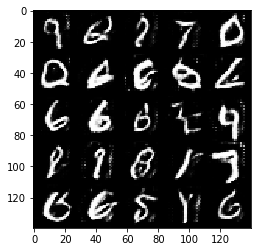

Epoch 1/2.	 Discriminator Loss: 1.3444;  Generator Loss: 0.8209
Epoch 1/2.	 Discriminator Loss: 1.2971;  Generator Loss: 2.0663
Epoch 1/2.	 Discriminator Loss: 1.2735;  Generator Loss: 0.5831
Epoch 1/2.	 Discriminator Loss: 1.2385;  Generator Loss: 0.9316
Epoch 1/2.	 Discriminator Loss: 1.1556;  Generator Loss: 0.9771
Epoch 1/2.	 Discriminator Loss: 1.5978;  Generator Loss: 1.1067
Epoch 1/2.	 Discriminator Loss: 1.5015;  Generator Loss: 0.4653
Epoch 1/2.	 Discriminator Loss: 0.7004;  Generator Loss: 1.3879
Epoch 1/2.	 Discriminator Loss: 0.8370;  Generator Loss: 1.4063
Epoch 1/2.	 Discriminator Loss: 1.5935;  Generator Loss: 0.3867


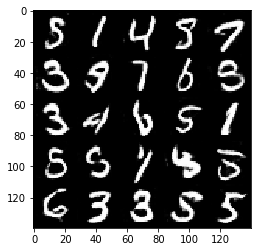

Epoch 1/2.	 Discriminator Loss: 1.4257;  Generator Loss: 0.7783
Epoch 1/2.	 Discriminator Loss: 1.6623;  Generator Loss: 0.4463
Epoch 1/2.	 Discriminator Loss: 0.7994;  Generator Loss: 1.7623
Epoch 1/2.	 Discriminator Loss: 0.8457;  Generator Loss: 1.1953
Epoch 1/2.	 Discriminator Loss: 1.2163;  Generator Loss: 0.7558
Epoch 1/2.	 Discriminator Loss: 1.0068;  Generator Loss: 0.9009
Epoch 1/2.	 Discriminator Loss: 1.1901;  Generator Loss: 0.6676
Epoch 1/2.	 Discriminator Loss: 1.4997;  Generator Loss: 0.3796
Epoch 1/2.	 Discriminator Loss: 1.5489;  Generator Loss: 0.4544
Epoch 1/2.	 Discriminator Loss: 1.0021;  Generator Loss: 1.1181


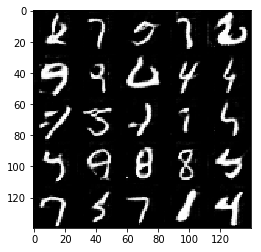

Epoch 1/2.	 Discriminator Loss: 1.0717;  Generator Loss: 1.7422
Epoch 1/2.	 Discriminator Loss: 0.9749;  Generator Loss: 1.4405
Epoch 1/2.	 Discriminator Loss: 1.2693;  Generator Loss: 1.2394
Epoch 1/2.	 Discriminator Loss: 1.0266;  Generator Loss: 0.7756
Epoch 1/2.	 Discriminator Loss: 0.8886;  Generator Loss: 1.3430
Epoch 2/2.	 Discriminator Loss: 0.7856;  Generator Loss: 1.6480
Epoch 2/2.	 Discriminator Loss: 0.6329;  Generator Loss: 1.6192
Epoch 2/2.	 Discriminator Loss: 0.9687;  Generator Loss: 1.0508
Epoch 2/2.	 Discriminator Loss: 0.8252;  Generator Loss: 1.2185
Epoch 2/2.	 Discriminator Loss: 1.1970;  Generator Loss: 0.6735


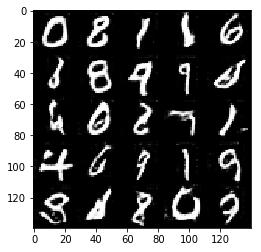

Epoch 2/2.	 Discriminator Loss: 1.1919;  Generator Loss: 0.9174
Epoch 2/2.	 Discriminator Loss: 0.8017;  Generator Loss: 1.2587
Epoch 2/2.	 Discriminator Loss: 1.4377;  Generator Loss: 0.4915
Epoch 2/2.	 Discriminator Loss: 0.8997;  Generator Loss: 1.0972
Epoch 2/2.	 Discriminator Loss: 0.9565;  Generator Loss: 0.8220
Epoch 2/2.	 Discriminator Loss: 0.8849;  Generator Loss: 0.6762
Epoch 2/2.	 Discriminator Loss: 1.2750;  Generator Loss: 0.7278
Epoch 2/2.	 Discriminator Loss: 0.6612;  Generator Loss: 2.1647
Epoch 2/2.	 Discriminator Loss: 1.6103;  Generator Loss: 0.5737
Epoch 2/2.	 Discriminator Loss: 1.4848;  Generator Loss: 0.7130


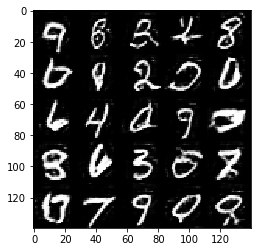

Epoch 2/2.	 Discriminator Loss: 0.9744;  Generator Loss: 0.6887
Epoch 2/2.	 Discriminator Loss: 1.0446;  Generator Loss: 0.9642
Epoch 2/2.	 Discriminator Loss: 1.3665;  Generator Loss: 0.8589
Epoch 2/2.	 Discriminator Loss: 0.9038;  Generator Loss: 1.3725
Epoch 2/2.	 Discriminator Loss: 1.3230;  Generator Loss: 0.6705
Epoch 2/2.	 Discriminator Loss: 0.6590;  Generator Loss: 1.4059
Epoch 2/2.	 Discriminator Loss: 0.6979;  Generator Loss: 2.2472
Epoch 2/2.	 Discriminator Loss: 1.2145;  Generator Loss: 0.8699
Epoch 2/2.	 Discriminator Loss: 0.8040;  Generator Loss: 1.4869
Epoch 2/2.	 Discriminator Loss: 0.9063;  Generator Loss: 1.0166


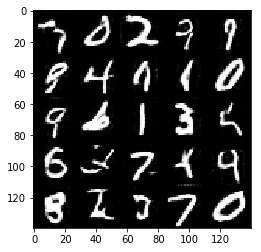

Epoch 2/2.	 Discriminator Loss: 0.8702;  Generator Loss: 1.4266
Epoch 2/2.	 Discriminator Loss: 0.7306;  Generator Loss: 2.1473
Epoch 2/2.	 Discriminator Loss: 1.3471;  Generator Loss: 0.4867
Epoch 2/2.	 Discriminator Loss: 1.5001;  Generator Loss: 0.4139
Epoch 2/2.	 Discriminator Loss: 0.9611;  Generator Loss: 1.0283
Epoch 2/2.	 Discriminator Loss: 2.2739;  Generator Loss: 0.2113
Epoch 2/2.	 Discriminator Loss: 0.9626;  Generator Loss: 0.9047
Epoch 2/2.	 Discriminator Loss: 1.1527;  Generator Loss: 1.3459
Epoch 2/2.	 Discriminator Loss: 0.9950;  Generator Loss: 1.4623
Epoch 2/2.	 Discriminator Loss: 1.2393;  Generator Loss: 0.5812


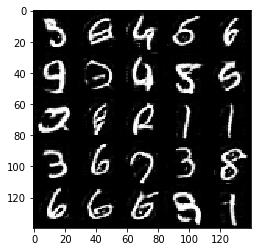

Epoch 2/2.	 Discriminator Loss: 1.1579;  Generator Loss: 1.0828
Epoch 2/2.	 Discriminator Loss: 0.9219;  Generator Loss: 1.5755
Epoch 2/2.	 Discriminator Loss: 1.1956;  Generator Loss: 0.9340
Epoch 2/2.	 Discriminator Loss: 1.0445;  Generator Loss: 0.8502
Epoch 2/2.	 Discriminator Loss: 1.3778;  Generator Loss: 1.2493
Epoch 2/2.	 Discriminator Loss: 1.0462;  Generator Loss: 1.0406
Epoch 2/2.	 Discriminator Loss: 0.9300;  Generator Loss: 1.0450
Epoch 2/2.	 Discriminator Loss: 1.2002;  Generator Loss: 1.0907
Epoch 2/2.	 Discriminator Loss: 1.1102;  Generator Loss: 0.8425
Epoch 2/2.	 Discriminator Loss: 0.6110;  Generator Loss: 1.4341


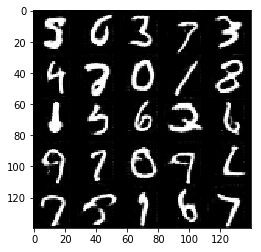

Epoch 2/2.	 Discriminator Loss: 0.9178;  Generator Loss: 0.9766
Epoch 2/2.	 Discriminator Loss: 1.1612;  Generator Loss: 0.9144
Epoch 2/2.	 Discriminator Loss: 0.8555;  Generator Loss: 0.9129
Epoch 2/2.	 Discriminator Loss: 1.2506;  Generator Loss: 1.3526
Epoch 2/2.	 Discriminator Loss: 1.2295;  Generator Loss: 0.6435
Epoch 2/2.	 Discriminator Loss: 1.4556;  Generator Loss: 0.7377
Epoch 2/2.	 Discriminator Loss: 0.8006;  Generator Loss: 1.1254
Epoch 2/2.	 Discriminator Loss: 1.1140;  Generator Loss: 1.1281
Epoch 2/2.	 Discriminator Loss: 1.0654;  Generator Loss: 0.6840
Epoch 2/2.	 Discriminator Loss: 0.8809;  Generator Loss: 1.0024


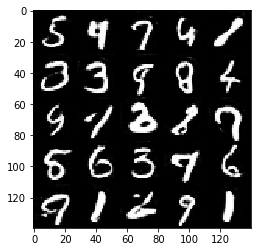

Epoch 2/2.	 Discriminator Loss: 0.9620;  Generator Loss: 1.1387
Epoch 2/2.	 Discriminator Loss: 1.0211;  Generator Loss: 1.4074
Epoch 2/2.	 Discriminator Loss: 0.7876;  Generator Loss: 1.4500
Epoch 2/2.	 Discriminator Loss: 1.1014;  Generator Loss: 1.6892
Epoch 2/2.	 Discriminator Loss: 0.9944;  Generator Loss: 0.9035
Epoch 2/2.	 Discriminator Loss: 0.9436;  Generator Loss: 0.9011
Epoch 2/2.	 Discriminator Loss: 1.0876;  Generator Loss: 0.5966
Epoch 2/2.	 Discriminator Loss: 0.6399;  Generator Loss: 1.6691
Epoch 2/2.	 Discriminator Loss: 0.9264;  Generator Loss: 2.0029
Epoch 2/2.	 Discriminator Loss: 1.1463;  Generator Loss: 0.8935


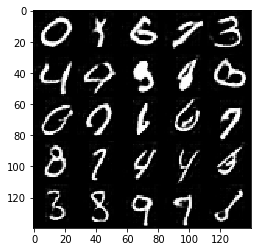

Epoch 2/2.	 Discriminator Loss: 0.7589;  Generator Loss: 1.5217
Epoch 2/2.	 Discriminator Loss: 1.2282;  Generator Loss: 0.8646
Epoch 2/2.	 Discriminator Loss: 0.8484;  Generator Loss: 1.1795
Epoch 2/2.	 Discriminator Loss: 1.0403;  Generator Loss: 1.1452
Epoch 2/2.	 Discriminator Loss: 1.4224;  Generator Loss: 0.4383
Epoch 2/2.	 Discriminator Loss: 0.9080;  Generator Loss: 1.4374
Epoch 2/2.	 Discriminator Loss: 1.0159;  Generator Loss: 1.1285
Epoch 2/2.	 Discriminator Loss: 1.0370;  Generator Loss: 1.5430
Epoch 2/2.	 Discriminator Loss: 1.2009;  Generator Loss: 0.7664
Epoch 2/2.	 Discriminator Loss: 1.0272;  Generator Loss: 1.2121


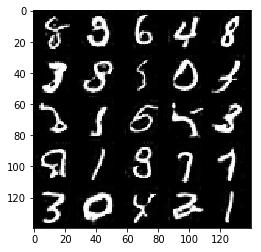

In [16]:
batch_size = 8
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1.	 Discriminator Loss: 1.7941;  Generator Loss: 1.1314
Epoch 1/1.	 Discriminator Loss: 1.3158;  Generator Loss: 2.6238
Epoch 1/1.	 Discriminator Loss: 0.9290;  Generator Loss: 1.0558
Epoch 1/1.	 Discriminator Loss: 1.2589;  Generator Loss: 0.6778
Epoch 1/1.	 Discriminator Loss: 1.4577;  Generator Loss: 0.9340
Epoch 1/1.	 Discriminator Loss: 2.1309;  Generator Loss: 0.2834
Epoch 1/1.	 Discriminator Loss: 0.6541;  Generator Loss: 1.4848
Epoch 1/1.	 Discriminator Loss: 1.5043;  Generator Loss: 0.5295
Epoch 1/1.	 Discriminator Loss: 1.3575;  Generator Loss: 0.5794
Epoch 1/1.	 Discriminator Loss: 1.5207;  Generator Loss: 0.5875


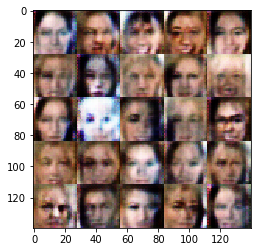

Epoch 1/1.	 Discriminator Loss: 1.3171;  Generator Loss: 0.5550
Epoch 1/1.	 Discriminator Loss: 1.7813;  Generator Loss: 0.5329
Epoch 1/1.	 Discriminator Loss: 1.4170;  Generator Loss: 0.3778
Epoch 1/1.	 Discriminator Loss: 2.1008;  Generator Loss: 0.4106
Epoch 1/1.	 Discriminator Loss: 1.3449;  Generator Loss: 0.5342
Epoch 1/1.	 Discriminator Loss: 1.6396;  Generator Loss: 0.7805
Epoch 1/1.	 Discriminator Loss: 1.1986;  Generator Loss: 0.8126
Epoch 1/1.	 Discriminator Loss: 1.7487;  Generator Loss: 0.5866
Epoch 1/1.	 Discriminator Loss: 1.4178;  Generator Loss: 0.8319
Epoch 1/1.	 Discriminator Loss: 1.3692;  Generator Loss: 0.7666


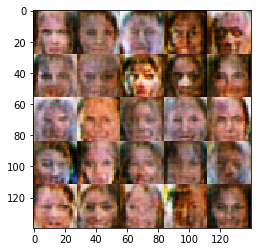

Epoch 1/1.	 Discriminator Loss: 1.4408;  Generator Loss: 0.7567
Epoch 1/1.	 Discriminator Loss: 1.3070;  Generator Loss: 0.7736
Epoch 1/1.	 Discriminator Loss: 1.2400;  Generator Loss: 0.7935
Epoch 1/1.	 Discriminator Loss: 1.0176;  Generator Loss: 0.9949
Epoch 1/1.	 Discriminator Loss: 1.5038;  Generator Loss: 0.6905
Epoch 1/1.	 Discriminator Loss: 1.3870;  Generator Loss: 0.8230
Epoch 1/1.	 Discriminator Loss: 1.5882;  Generator Loss: 0.5565
Epoch 1/1.	 Discriminator Loss: 1.3942;  Generator Loss: 0.8039
Epoch 1/1.	 Discriminator Loss: 1.4664;  Generator Loss: 0.5314
Epoch 1/1.	 Discriminator Loss: 1.4343;  Generator Loss: 0.7541


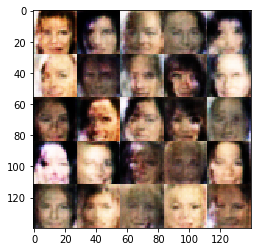

Epoch 1/1.	 Discriminator Loss: 1.2277;  Generator Loss: 0.9217
Epoch 1/1.	 Discriminator Loss: 1.4782;  Generator Loss: 0.7871
Epoch 1/1.	 Discriminator Loss: 1.5241;  Generator Loss: 0.4946
Epoch 1/1.	 Discriminator Loss: 1.4233;  Generator Loss: 0.7261
Epoch 1/1.	 Discriminator Loss: 1.3315;  Generator Loss: 0.6053
Epoch 1/1.	 Discriminator Loss: 1.4266;  Generator Loss: 0.8020
Epoch 1/1.	 Discriminator Loss: 1.3237;  Generator Loss: 0.6307
Epoch 1/1.	 Discriminator Loss: 1.5440;  Generator Loss: 1.0266
Epoch 1/1.	 Discriminator Loss: 1.1629;  Generator Loss: 0.9564
Epoch 1/1.	 Discriminator Loss: 1.6041;  Generator Loss: 0.6298


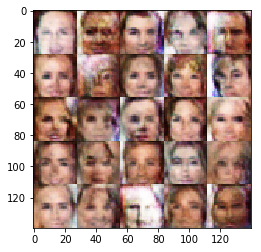

Epoch 1/1.	 Discriminator Loss: 1.4399;  Generator Loss: 0.7002
Epoch 1/1.	 Discriminator Loss: 1.2927;  Generator Loss: 0.9916
Epoch 1/1.	 Discriminator Loss: 1.4257;  Generator Loss: 0.6127
Epoch 1/1.	 Discriminator Loss: 1.4642;  Generator Loss: 0.7742
Epoch 1/1.	 Discriminator Loss: 1.2037;  Generator Loss: 0.7716
Epoch 1/1.	 Discriminator Loss: 1.4692;  Generator Loss: 0.6228
Epoch 1/1.	 Discriminator Loss: 1.2739;  Generator Loss: 0.9201
Epoch 1/1.	 Discriminator Loss: 1.3903;  Generator Loss: 0.7144
Epoch 1/1.	 Discriminator Loss: 1.2906;  Generator Loss: 0.9603
Epoch 1/1.	 Discriminator Loss: 1.4508;  Generator Loss: 0.9243


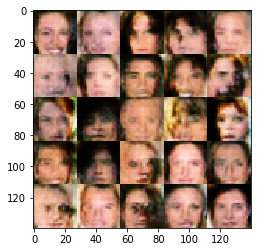

Epoch 1/1.	 Discriminator Loss: 1.2507;  Generator Loss: 0.7780
Epoch 1/1.	 Discriminator Loss: 1.3625;  Generator Loss: 0.8704
Epoch 1/1.	 Discriminator Loss: 1.4044;  Generator Loss: 0.7771
Epoch 1/1.	 Discriminator Loss: 1.5026;  Generator Loss: 0.8086
Epoch 1/1.	 Discriminator Loss: 1.4123;  Generator Loss: 0.6862
Epoch 1/1.	 Discriminator Loss: 1.4563;  Generator Loss: 0.7992
Epoch 1/1.	 Discriminator Loss: 1.4429;  Generator Loss: 0.9480
Epoch 1/1.	 Discriminator Loss: 1.3772;  Generator Loss: 0.7492
Epoch 1/1.	 Discriminator Loss: 1.3969;  Generator Loss: 0.7816
Epoch 1/1.	 Discriminator Loss: 1.4594;  Generator Loss: 0.8300


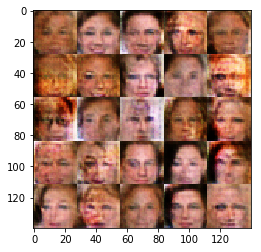

Epoch 1/1.	 Discriminator Loss: 1.2374;  Generator Loss: 0.9877
Epoch 1/1.	 Discriminator Loss: 1.4769;  Generator Loss: 0.8302
Epoch 1/1.	 Discriminator Loss: 1.5805;  Generator Loss: 0.7765
Epoch 1/1.	 Discriminator Loss: 1.2746;  Generator Loss: 0.8830
Epoch 1/1.	 Discriminator Loss: 1.1582;  Generator Loss: 0.7543
Epoch 1/1.	 Discriminator Loss: 1.3954;  Generator Loss: 0.6666
Epoch 1/1.	 Discriminator Loss: 1.4007;  Generator Loss: 0.6142
Epoch 1/1.	 Discriminator Loss: 1.4048;  Generator Loss: 0.7733
Epoch 1/1.	 Discriminator Loss: 1.1431;  Generator Loss: 0.7239
Epoch 1/1.	 Discriminator Loss: 1.2530;  Generator Loss: 0.8079


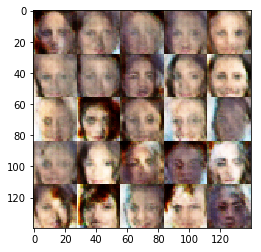

Epoch 1/1.	 Discriminator Loss: 1.0960;  Generator Loss: 1.0899
Epoch 1/1.	 Discriminator Loss: 1.4275;  Generator Loss: 0.8343
Epoch 1/1.	 Discriminator Loss: 1.5461;  Generator Loss: 0.7037
Epoch 1/1.	 Discriminator Loss: 1.2073;  Generator Loss: 0.7718
Epoch 1/1.	 Discriminator Loss: 1.4350;  Generator Loss: 0.6544
Epoch 1/1.	 Discriminator Loss: 1.5227;  Generator Loss: 0.6083
Epoch 1/1.	 Discriminator Loss: 1.3435;  Generator Loss: 0.9687
Epoch 1/1.	 Discriminator Loss: 1.4489;  Generator Loss: 0.7307
Epoch 1/1.	 Discriminator Loss: 1.4337;  Generator Loss: 0.7443
Epoch 1/1.	 Discriminator Loss: 1.3220;  Generator Loss: 0.6986


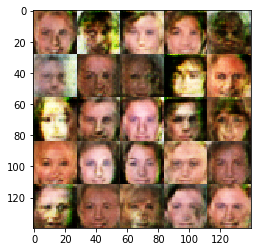

Epoch 1/1.	 Discriminator Loss: 1.3961;  Generator Loss: 0.7745
Epoch 1/1.	 Discriminator Loss: 1.7173;  Generator Loss: 0.5653
Epoch 1/1.	 Discriminator Loss: 1.3005;  Generator Loss: 1.1311
Epoch 1/1.	 Discriminator Loss: 1.3422;  Generator Loss: 0.7169
Epoch 1/1.	 Discriminator Loss: 1.3596;  Generator Loss: 0.7868
Epoch 1/1.	 Discriminator Loss: 1.2059;  Generator Loss: 0.9688
Epoch 1/1.	 Discriminator Loss: 1.4305;  Generator Loss: 0.8051
Epoch 1/1.	 Discriminator Loss: 1.4792;  Generator Loss: 0.8085
Epoch 1/1.	 Discriminator Loss: 1.5563;  Generator Loss: 0.6792
Epoch 1/1.	 Discriminator Loss: 1.5685;  Generator Loss: 0.6244


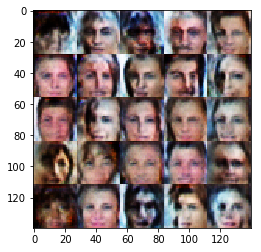

Epoch 1/1.	 Discriminator Loss: 1.4084;  Generator Loss: 0.7120
Epoch 1/1.	 Discriminator Loss: 1.2029;  Generator Loss: 0.8376
Epoch 1/1.	 Discriminator Loss: 1.6636;  Generator Loss: 0.5301
Epoch 1/1.	 Discriminator Loss: 1.2438;  Generator Loss: 0.7741
Epoch 1/1.	 Discriminator Loss: 1.3312;  Generator Loss: 0.8146
Epoch 1/1.	 Discriminator Loss: 1.3027;  Generator Loss: 0.8633
Epoch 1/1.	 Discriminator Loss: 1.3227;  Generator Loss: 0.7595
Epoch 1/1.	 Discriminator Loss: 1.4343;  Generator Loss: 0.8153
Epoch 1/1.	 Discriminator Loss: 1.3384;  Generator Loss: 0.7745
Epoch 1/1.	 Discriminator Loss: 1.3155;  Generator Loss: 0.8656


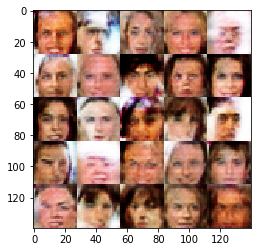

Epoch 1/1.	 Discriminator Loss: 1.2900;  Generator Loss: 0.7570
Epoch 1/1.	 Discriminator Loss: 1.2494;  Generator Loss: 0.7717
Epoch 1/1.	 Discriminator Loss: 1.3340;  Generator Loss: 0.7278
Epoch 1/1.	 Discriminator Loss: 1.3559;  Generator Loss: 0.7010
Epoch 1/1.	 Discriminator Loss: 1.4464;  Generator Loss: 0.7547
Epoch 1/1.	 Discriminator Loss: 1.3825;  Generator Loss: 0.8121
Epoch 1/1.	 Discriminator Loss: 1.2389;  Generator Loss: 0.8740
Epoch 1/1.	 Discriminator Loss: 1.4104;  Generator Loss: 0.7429
Epoch 1/1.	 Discriminator Loss: 1.2951;  Generator Loss: 0.6580
Epoch 1/1.	 Discriminator Loss: 1.1904;  Generator Loss: 0.7890


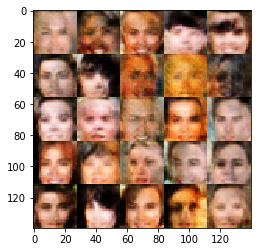

Epoch 1/1.	 Discriminator Loss: 1.3277;  Generator Loss: 0.6787
Epoch 1/1.	 Discriminator Loss: 1.2956;  Generator Loss: 0.8753
Epoch 1/1.	 Discriminator Loss: 1.2539;  Generator Loss: 0.8125
Epoch 1/1.	 Discriminator Loss: 1.4507;  Generator Loss: 0.8741
Epoch 1/1.	 Discriminator Loss: 1.2740;  Generator Loss: 0.8068
Epoch 1/1.	 Discriminator Loss: 1.4802;  Generator Loss: 0.6276
Epoch 1/1.	 Discriminator Loss: 1.4658;  Generator Loss: 0.7379
Epoch 1/1.	 Discriminator Loss: 1.3063;  Generator Loss: 0.8565
Epoch 1/1.	 Discriminator Loss: 1.3990;  Generator Loss: 0.7075
Epoch 1/1.	 Discriminator Loss: 1.2037;  Generator Loss: 1.0192


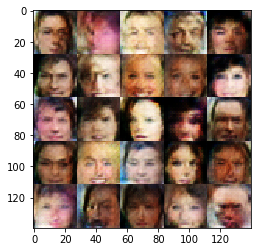

Epoch 1/1.	 Discriminator Loss: 1.3581;  Generator Loss: 0.7595
Epoch 1/1.	 Discriminator Loss: 1.3818;  Generator Loss: 0.7627
Epoch 1/1.	 Discriminator Loss: 1.3590;  Generator Loss: 0.7072
Epoch 1/1.	 Discriminator Loss: 1.5151;  Generator Loss: 0.5851
Epoch 1/1.	 Discriminator Loss: 1.3647;  Generator Loss: 0.7333
Epoch 1/1.	 Discriminator Loss: 1.4737;  Generator Loss: 0.7510
Epoch 1/1.	 Discriminator Loss: 1.4702;  Generator Loss: 0.7686
Epoch 1/1.	 Discriminator Loss: 1.3362;  Generator Loss: 0.6627
Epoch 1/1.	 Discriminator Loss: 1.5918;  Generator Loss: 0.6057
Epoch 1/1.	 Discriminator Loss: 1.5353;  Generator Loss: 0.6793


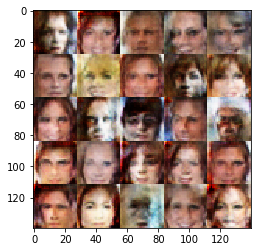

Epoch 1/1.	 Discriminator Loss: 1.2270;  Generator Loss: 0.8699
Epoch 1/1.	 Discriminator Loss: 1.3102;  Generator Loss: 0.8287
Epoch 1/1.	 Discriminator Loss: 1.3920;  Generator Loss: 0.6382
Epoch 1/1.	 Discriminator Loss: 1.3356;  Generator Loss: 0.7969
Epoch 1/1.	 Discriminator Loss: 1.2912;  Generator Loss: 0.7202
Epoch 1/1.	 Discriminator Loss: 1.3210;  Generator Loss: 0.7889
Epoch 1/1.	 Discriminator Loss: 1.3780;  Generator Loss: 0.6632
Epoch 1/1.	 Discriminator Loss: 1.3385;  Generator Loss: 0.6625
Epoch 1/1.	 Discriminator Loss: 1.3524;  Generator Loss: 0.8235
Epoch 1/1.	 Discriminator Loss: 1.3891;  Generator Loss: 0.7094


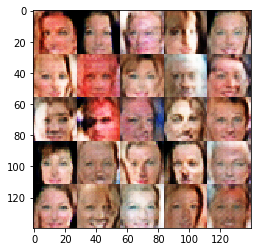

Epoch 1/1.	 Discriminator Loss: 1.1936;  Generator Loss: 0.7224
Epoch 1/1.	 Discriminator Loss: 1.5227;  Generator Loss: 0.6701
Epoch 1/1.	 Discriminator Loss: 1.2763;  Generator Loss: 0.8718
Epoch 1/1.	 Discriminator Loss: 1.3465;  Generator Loss: 0.7931
Epoch 1/1.	 Discriminator Loss: 1.3834;  Generator Loss: 0.7648
Epoch 1/1.	 Discriminator Loss: 1.4425;  Generator Loss: 0.7187
Epoch 1/1.	 Discriminator Loss: 1.3013;  Generator Loss: 0.8834
Epoch 1/1.	 Discriminator Loss: 1.2389;  Generator Loss: 0.7835
Epoch 1/1.	 Discriminator Loss: 1.2331;  Generator Loss: 0.8059
Epoch 1/1.	 Discriminator Loss: 1.4862;  Generator Loss: 0.6716


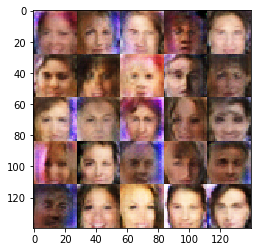

Epoch 1/1.	 Discriminator Loss: 1.4483;  Generator Loss: 0.6774
Epoch 1/1.	 Discriminator Loss: 1.4707;  Generator Loss: 0.8860
Epoch 1/1.	 Discriminator Loss: 1.3757;  Generator Loss: 0.7128
Epoch 1/1.	 Discriminator Loss: 1.4100;  Generator Loss: 0.7360
Epoch 1/1.	 Discriminator Loss: 1.3547;  Generator Loss: 0.7416
Epoch 1/1.	 Discriminator Loss: 1.2935;  Generator Loss: 0.7391
Epoch 1/1.	 Discriminator Loss: 1.3602;  Generator Loss: 0.7758
Epoch 1/1.	 Discriminator Loss: 1.3355;  Generator Loss: 0.9081
Epoch 1/1.	 Discriminator Loss: 1.3262;  Generator Loss: 0.7502
Epoch 1/1.	 Discriminator Loss: 1.3964;  Generator Loss: 0.7635


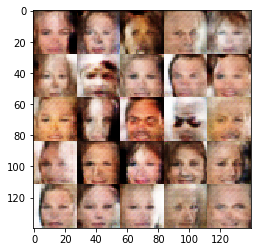

Epoch 1/1.	 Discriminator Loss: 1.4286;  Generator Loss: 0.7456
Epoch 1/1.	 Discriminator Loss: 1.4789;  Generator Loss: 0.6094
Epoch 1/1.	 Discriminator Loss: 1.3759;  Generator Loss: 0.8397
Epoch 1/1.	 Discriminator Loss: 1.3950;  Generator Loss: 0.7721
Epoch 1/1.	 Discriminator Loss: 1.3247;  Generator Loss: 0.8318
Epoch 1/1.	 Discriminator Loss: 1.3980;  Generator Loss: 0.7147
Epoch 1/1.	 Discriminator Loss: 1.3880;  Generator Loss: 0.7097
Epoch 1/1.	 Discriminator Loss: 1.4229;  Generator Loss: 0.6495
Epoch 1/1.	 Discriminator Loss: 1.3370;  Generator Loss: 0.7465
Epoch 1/1.	 Discriminator Loss: 1.4280;  Generator Loss: 0.7588


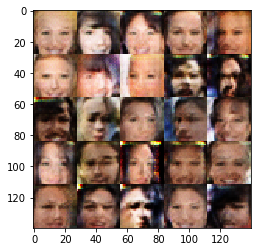

Epoch 1/1.	 Discriminator Loss: 1.3293;  Generator Loss: 0.8186
Epoch 1/1.	 Discriminator Loss: 1.3685;  Generator Loss: 0.7593
Epoch 1/1.	 Discriminator Loss: 1.5263;  Generator Loss: 0.7381
Epoch 1/1.	 Discriminator Loss: 1.5306;  Generator Loss: 0.6811
Epoch 1/1.	 Discriminator Loss: 1.4839;  Generator Loss: 0.7239
Epoch 1/1.	 Discriminator Loss: 1.4564;  Generator Loss: 0.7799
Epoch 1/1.	 Discriminator Loss: 1.3207;  Generator Loss: 0.7785
Epoch 1/1.	 Discriminator Loss: 1.3677;  Generator Loss: 0.7954
Epoch 1/1.	 Discriminator Loss: 1.3517;  Generator Loss: 0.7501
Epoch 1/1.	 Discriminator Loss: 1.3179;  Generator Loss: 0.8156


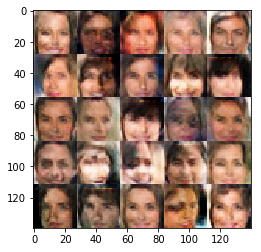

Epoch 1/1.	 Discriminator Loss: 1.3100;  Generator Loss: 0.8153
Epoch 1/1.	 Discriminator Loss: 1.3422;  Generator Loss: 0.7193
Epoch 1/1.	 Discriminator Loss: 1.4270;  Generator Loss: 0.7084
Epoch 1/1.	 Discriminator Loss: 1.3753;  Generator Loss: 0.8712
Epoch 1/1.	 Discriminator Loss: 1.4559;  Generator Loss: 0.7183
Epoch 1/1.	 Discriminator Loss: 1.3479;  Generator Loss: 0.7555
Epoch 1/1.	 Discriminator Loss: 1.3749;  Generator Loss: 0.7687
Epoch 1/1.	 Discriminator Loss: 1.4663;  Generator Loss: 0.6827
Epoch 1/1.	 Discriminator Loss: 1.4690;  Generator Loss: 0.6671
Epoch 1/1.	 Discriminator Loss: 1.2976;  Generator Loss: 0.7780


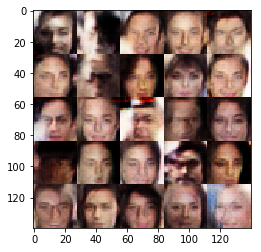

Epoch 1/1.	 Discriminator Loss: 1.4105;  Generator Loss: 0.7924
Epoch 1/1.	 Discriminator Loss: 1.4056;  Generator Loss: 0.7485
Epoch 1/1.	 Discriminator Loss: 1.3599;  Generator Loss: 0.8208
Epoch 1/1.	 Discriminator Loss: 1.2978;  Generator Loss: 0.7194
Epoch 1/1.	 Discriminator Loss: 1.2768;  Generator Loss: 0.7628
Epoch 1/1.	 Discriminator Loss: 1.4466;  Generator Loss: 0.7488
Epoch 1/1.	 Discriminator Loss: 1.3868;  Generator Loss: 0.7604
Epoch 1/1.	 Discriminator Loss: 1.4425;  Generator Loss: 0.7624
Epoch 1/1.	 Discriminator Loss: 1.3791;  Generator Loss: 0.7597
Epoch 1/1.	 Discriminator Loss: 1.3033;  Generator Loss: 0.8004


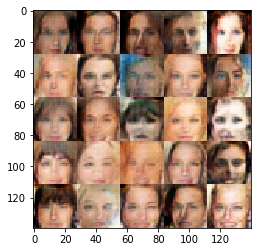

Epoch 1/1.	 Discriminator Loss: 1.3522;  Generator Loss: 0.7767
Epoch 1/1.	 Discriminator Loss: 1.3959;  Generator Loss: 0.8387
Epoch 1/1.	 Discriminator Loss: 1.3943;  Generator Loss: 0.7787
Epoch 1/1.	 Discriminator Loss: 1.3174;  Generator Loss: 0.8782
Epoch 1/1.	 Discriminator Loss: 1.4630;  Generator Loss: 0.6916
Epoch 1/1.	 Discriminator Loss: 1.4124;  Generator Loss: 0.7564
Epoch 1/1.	 Discriminator Loss: 1.3281;  Generator Loss: 0.7803
Epoch 1/1.	 Discriminator Loss: 1.3640;  Generator Loss: 0.7312
Epoch 1/1.	 Discriminator Loss: 1.4053;  Generator Loss: 0.8375
Epoch 1/1.	 Discriminator Loss: 1.3414;  Generator Loss: 0.7414


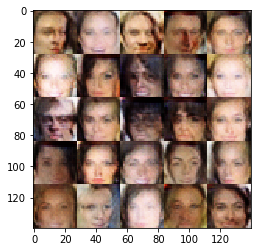

Epoch 1/1.	 Discriminator Loss: 1.3068;  Generator Loss: 0.6889
Epoch 1/1.	 Discriminator Loss: 1.3711;  Generator Loss: 0.7969
Epoch 1/1.	 Discriminator Loss: 1.4987;  Generator Loss: 0.7711
Epoch 1/1.	 Discriminator Loss: 1.4365;  Generator Loss: 0.7347
Epoch 1/1.	 Discriminator Loss: 1.3468;  Generator Loss: 0.7809
Epoch 1/1.	 Discriminator Loss: 1.3752;  Generator Loss: 0.6756
Epoch 1/1.	 Discriminator Loss: 1.4409;  Generator Loss: 0.7812
Epoch 1/1.	 Discriminator Loss: 1.5117;  Generator Loss: 0.7441
Epoch 1/1.	 Discriminator Loss: 1.3787;  Generator Loss: 0.7331
Epoch 1/1.	 Discriminator Loss: 1.3992;  Generator Loss: 0.8123


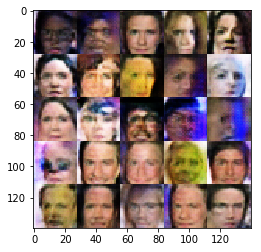

Epoch 1/1.	 Discriminator Loss: 1.3460;  Generator Loss: 0.7834
Epoch 1/1.	 Discriminator Loss: 1.4050;  Generator Loss: 0.7614
Epoch 1/1.	 Discriminator Loss: 1.3982;  Generator Loss: 0.8323
Epoch 1/1.	 Discriminator Loss: 1.4525;  Generator Loss: 0.7031
Epoch 1/1.	 Discriminator Loss: 1.4405;  Generator Loss: 0.7297
Epoch 1/1.	 Discriminator Loss: 1.3539;  Generator Loss: 0.7944
Epoch 1/1.	 Discriminator Loss: 1.3857;  Generator Loss: 0.7609
Epoch 1/1.	 Discriminator Loss: 1.4298;  Generator Loss: 0.7649
Epoch 1/1.	 Discriminator Loss: 1.3426;  Generator Loss: 0.7819
Epoch 1/1.	 Discriminator Loss: 1.4013;  Generator Loss: 0.7830


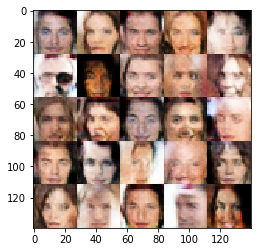

Epoch 1/1.	 Discriminator Loss: 1.4118;  Generator Loss: 0.8112
Epoch 1/1.	 Discriminator Loss: 1.2886;  Generator Loss: 0.8895
Epoch 1/1.	 Discriminator Loss: 1.5141;  Generator Loss: 0.6937
Epoch 1/1.	 Discriminator Loss: 1.3357;  Generator Loss: 0.8042
Epoch 1/1.	 Discriminator Loss: 1.3774;  Generator Loss: 0.6984
Epoch 1/1.	 Discriminator Loss: 1.4654;  Generator Loss: 0.6476
Epoch 1/1.	 Discriminator Loss: 1.2497;  Generator Loss: 0.8360
Epoch 1/1.	 Discriminator Loss: 1.3938;  Generator Loss: 0.8372
Epoch 1/1.	 Discriminator Loss: 1.2530;  Generator Loss: 0.7772
Epoch 1/1.	 Discriminator Loss: 1.4457;  Generator Loss: 0.6659


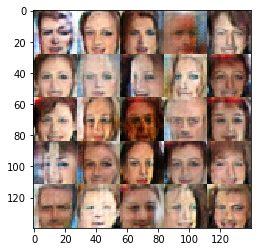

Epoch 1/1.	 Discriminator Loss: 1.3735;  Generator Loss: 0.7758
Epoch 1/1.	 Discriminator Loss: 1.3980;  Generator Loss: 0.7937
Epoch 1/1.	 Discriminator Loss: 1.3660;  Generator Loss: 0.7707
Epoch 1/1.	 Discriminator Loss: 1.3967;  Generator Loss: 0.8039
Epoch 1/1.	 Discriminator Loss: 1.2834;  Generator Loss: 0.8225
Epoch 1/1.	 Discriminator Loss: 1.3606;  Generator Loss: 0.8217
Epoch 1/1.	 Discriminator Loss: 1.3290;  Generator Loss: 0.8670
Epoch 1/1.	 Discriminator Loss: 1.3665;  Generator Loss: 0.7765
Epoch 1/1.	 Discriminator Loss: 1.5153;  Generator Loss: 0.6463
Epoch 1/1.	 Discriminator Loss: 1.4624;  Generator Loss: 0.6915


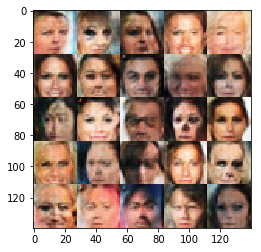

Epoch 1/1.	 Discriminator Loss: 1.3269;  Generator Loss: 0.8434
Epoch 1/1.	 Discriminator Loss: 1.2970;  Generator Loss: 0.7666
Epoch 1/1.	 Discriminator Loss: 1.4179;  Generator Loss: 0.7924


In [17]:
batch_size = 8
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.